In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/IRP/irp-hz122

/content/drive/MyDrive/IRP/irp-hz122


In [3]:
! pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 3.7 MB/s eta 0:00:00


In [4]:
from models import dataloader, model, results_plot
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from ignite.metrics import SSIM

In [5]:
device = 'cuda'

In [6]:
# Set parameters
lookback = 3
lookahead = 3
batch_size = 20
num_epochs = 30

# Burgers' Equation

## load data

In [7]:
test_data = torch.from_numpy(np.load('data/test_sw_10_300_0001_64_rm30.npy')).to(device).float()

# test_data = dataloader.load_data('data/test_sw_10_300_0001_64_rm30.npy', model='LSTM')

In [8]:
initial_predict_data = test_data[:,150:153,:]
test_data = test_data[:,150:,:]

## Set MSPC-LSTM

In [9]:
# add dense in Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)  # output size: 32x32
        self.conv2 = nn.Conv2d(32, 16, 3, stride=2, padding=1)  # output size: 16x16
        self.dense = nn.Linear(16 * 16 * 16, 512)  # Added dense layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.dense(x) # F.relu(self.dense(x))  # Apply dense layer
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense = nn.Linear(512, 16 * 16 * 16)  # Added dense layer
        self.t_conv1 = nn.ConvTranspose2d(16, 32, 3, stride=2, padding=1, output_padding=1)  # output size: 32x32
        self.t_conv2 = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1)  # output size: 64x64

    def forward(self, x):
        x = self.dense(x) # F.relu(self.dense(x))  # Apply dense layer
        x = x.view(x.size(0), 16, 16, 16)  # Reshape the input
        x = F.relu(self.t_conv1(x))
        x = self.t_conv2(x)  # No activation here
        return x


class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [10]:
class low_Encoder(nn.Module):
    def __init__(self):
        super(low_Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)  # output size: 16x16
        self.conv2 = nn.Conv2d(16, 16, 3, stride=2, padding=1)  # output size: 8x8
        self.dense = nn.Linear(16 * 8 * 8, 512)  # Added dense layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.dense(x) # F.relu(self.dense(x))  # Apply dense layer
        return x


class low_Decoder(nn.Module):
    def __init__(self):
        super(low_Decoder, self).__init__()
        self.dense = nn.Linear(512, 16 * 8 * 8)  # Added dense layer
        self.t_conv1 = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1, output_padding=1)  # output size: 16x16
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)  # output size: 32x32

    def forward(self, x):
        x = self.dense(x) # F.relu(self.dense(x))  # Apply dense layer
        x = x.view(x.size(0), 16, 8, 8)  # Reshape the input
        x = F.relu(self.t_conv1(x))
        x = self.t_conv2(x)  # No activation here
        return x

In [11]:
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(Seq2Seq, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  # we only want the last 3 time steps

        return out

In [12]:
# initialize basic MSPC-LSTM
HF_CAE = torch.load("model_paths/sw_highcae.pth")
LF_CAE = torch.load("model_paths/sw_lowcae.pth")
basic_LSTM = torch.load("model_paths/sw_basic_lstm.pth")
sw_basic_MSPC = model.SW_MSPC_LSTM(HF_CAE, LF_CAE, basic_LSTM)

In [13]:
# initialize energy constraint MSPC-LSTM
ec_low_LSTM = torch.load("model_paths/sw_lstm_low_ec.pth")
sw_lf_ec_MSPC = model.SW_MSPC_LSTM(HF_CAE, LF_CAE, ec_low_LSTM)

In [14]:
# initialize flow operator MSPC-LSTM
fo_low_LSTM = torch.load("model_paths/sw_lstm_low_fo.pth")
sw_lf_fo_MSPC = model.SW_MSPC_LSTM(HF_CAE, LF_CAE, fo_low_LSTM)

In [15]:
# initialize multiple constraints MSPC-LSTM
multi_low_LSTM = torch.load("model_paths/sw_lstm_low_multi.pth")
sw_lf_multi_MSPC = model.SW_MSPC_LSTM(HF_CAE, LF_CAE, multi_low_LSTM)

## Predict

In [16]:
# predict results
basic_predictions = sw_basic_MSPC.predict(initial_predict_data, 3, 49)
lf_ec_predictions = sw_lf_ec_MSPC.predict(initial_predict_data, 3, 49)
lf_fo_predictions = sw_lf_fo_MSPC.predict(initial_predict_data, 3, 49)
lf_multi_predictions = sw_lf_multi_MSPC.predict(initial_predict_data, 3, 49)

## Evaluate Predictions

In [17]:
reconstructed_data = HF_CAE(test_data.reshape(-1,3,64,64)).reshape(10,150,3,64,64)

In [18]:
basic_loss, basic_std = results_plot.get_seperate_loss_std(basic_predictions, test_data)
lf_ec_loss, lf_ec_std = results_plot.get_seperate_loss_std(lf_ec_predictions, test_data)
lf_fo_loss, lf_fo_std = results_plot.get_seperate_loss_std(lf_fo_predictions, test_data)
lf_multi_loss, lf_multi_std = results_plot.get_seperate_loss_std(lf_multi_predictions, test_data)

In [19]:
ssim = SSIM(data_range=1.0)
basic_ssim = results_plot.calculate_ssim(basic_predictions, reconstructed_data, ssim)
lf_ec_ssim = results_plot.calculate_ssim(lf_ec_predictions, reconstructed_data, ssim)
lf_fo_ssim = results_plot.calculate_ssim(lf_fo_predictions, reconstructed_data, ssim)
lf_multi_ssim = results_plot.calculate_ssim(lf_multi_predictions, reconstructed_data, ssim)

## plot results

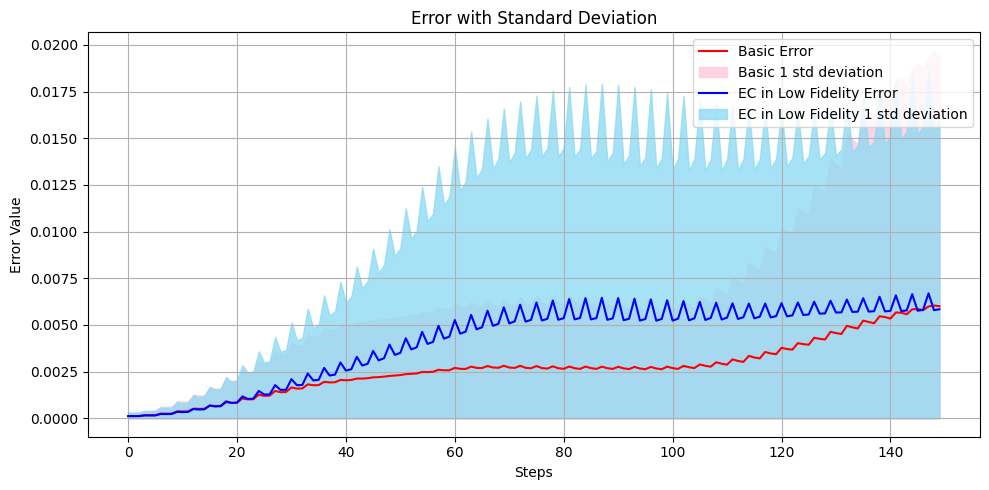

In [20]:
x = np.arange(len(lf_ec_loss))
y_values = [np.array(basic_loss), np.array(lf_ec_loss)]  # Add more error lists as needed
std_values = [np.array(basic_std), np.array(lf_ec_std)]    # Add more std lists as needed
labels = ['Basic', 'EC in Low Fidelity']  # Add more labels as needed

results_plot.plot_errors_with_std(x, y_values, std_values, labels)

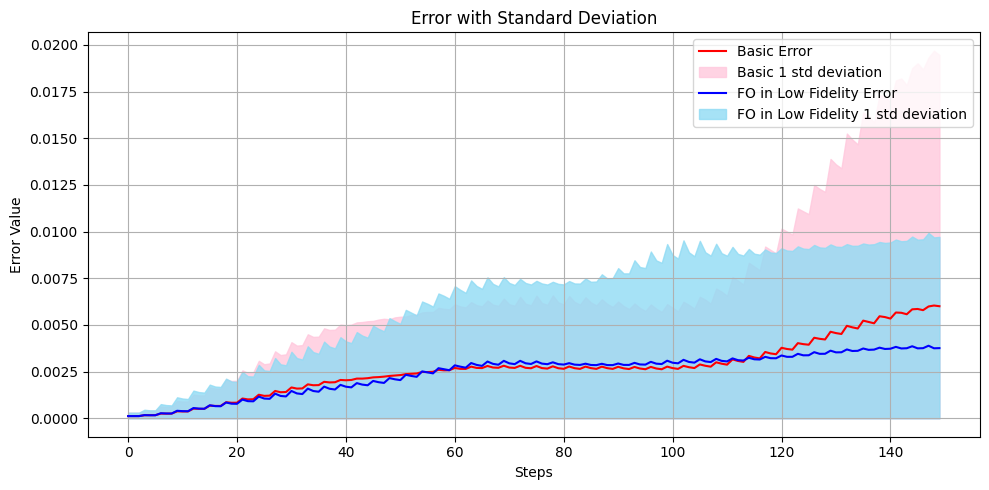

In [21]:
x = np.arange(len(lf_fo_loss))
y_values = [np.array(basic_loss), np.array(lf_fo_loss)]  # Add more error lists as needed
std_values = [np.array(basic_std), np.array(lf_fo_std)]    # Add more std lists as needed
labels = ['Basic', 'FO in Low Fidelity']  # Add more labels as needed

results_plot.plot_errors_with_std(x, y_values, std_values, labels)

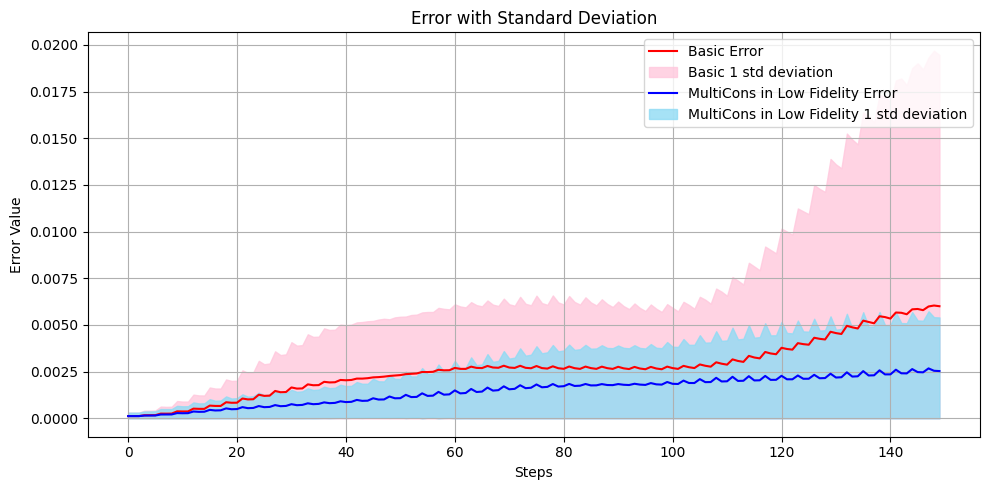

In [22]:
x = np.arange(len(lf_fo_loss))
y_values = [np.array(basic_loss), np.array(lf_multi_loss)]  # Add more error lists as needed
std_values = [np.array(basic_std), np.array(lf_multi_std)]    # Add more std lists as needed
labels = ['Basic', 'MultiCons in Low Fidelity']  # Add more labels as needed

results_plot.plot_errors_with_std(x, y_values, std_values, labels)

In [23]:
nDisplay = 4
num = [9, 24, 98, 149]
batch_num = 0

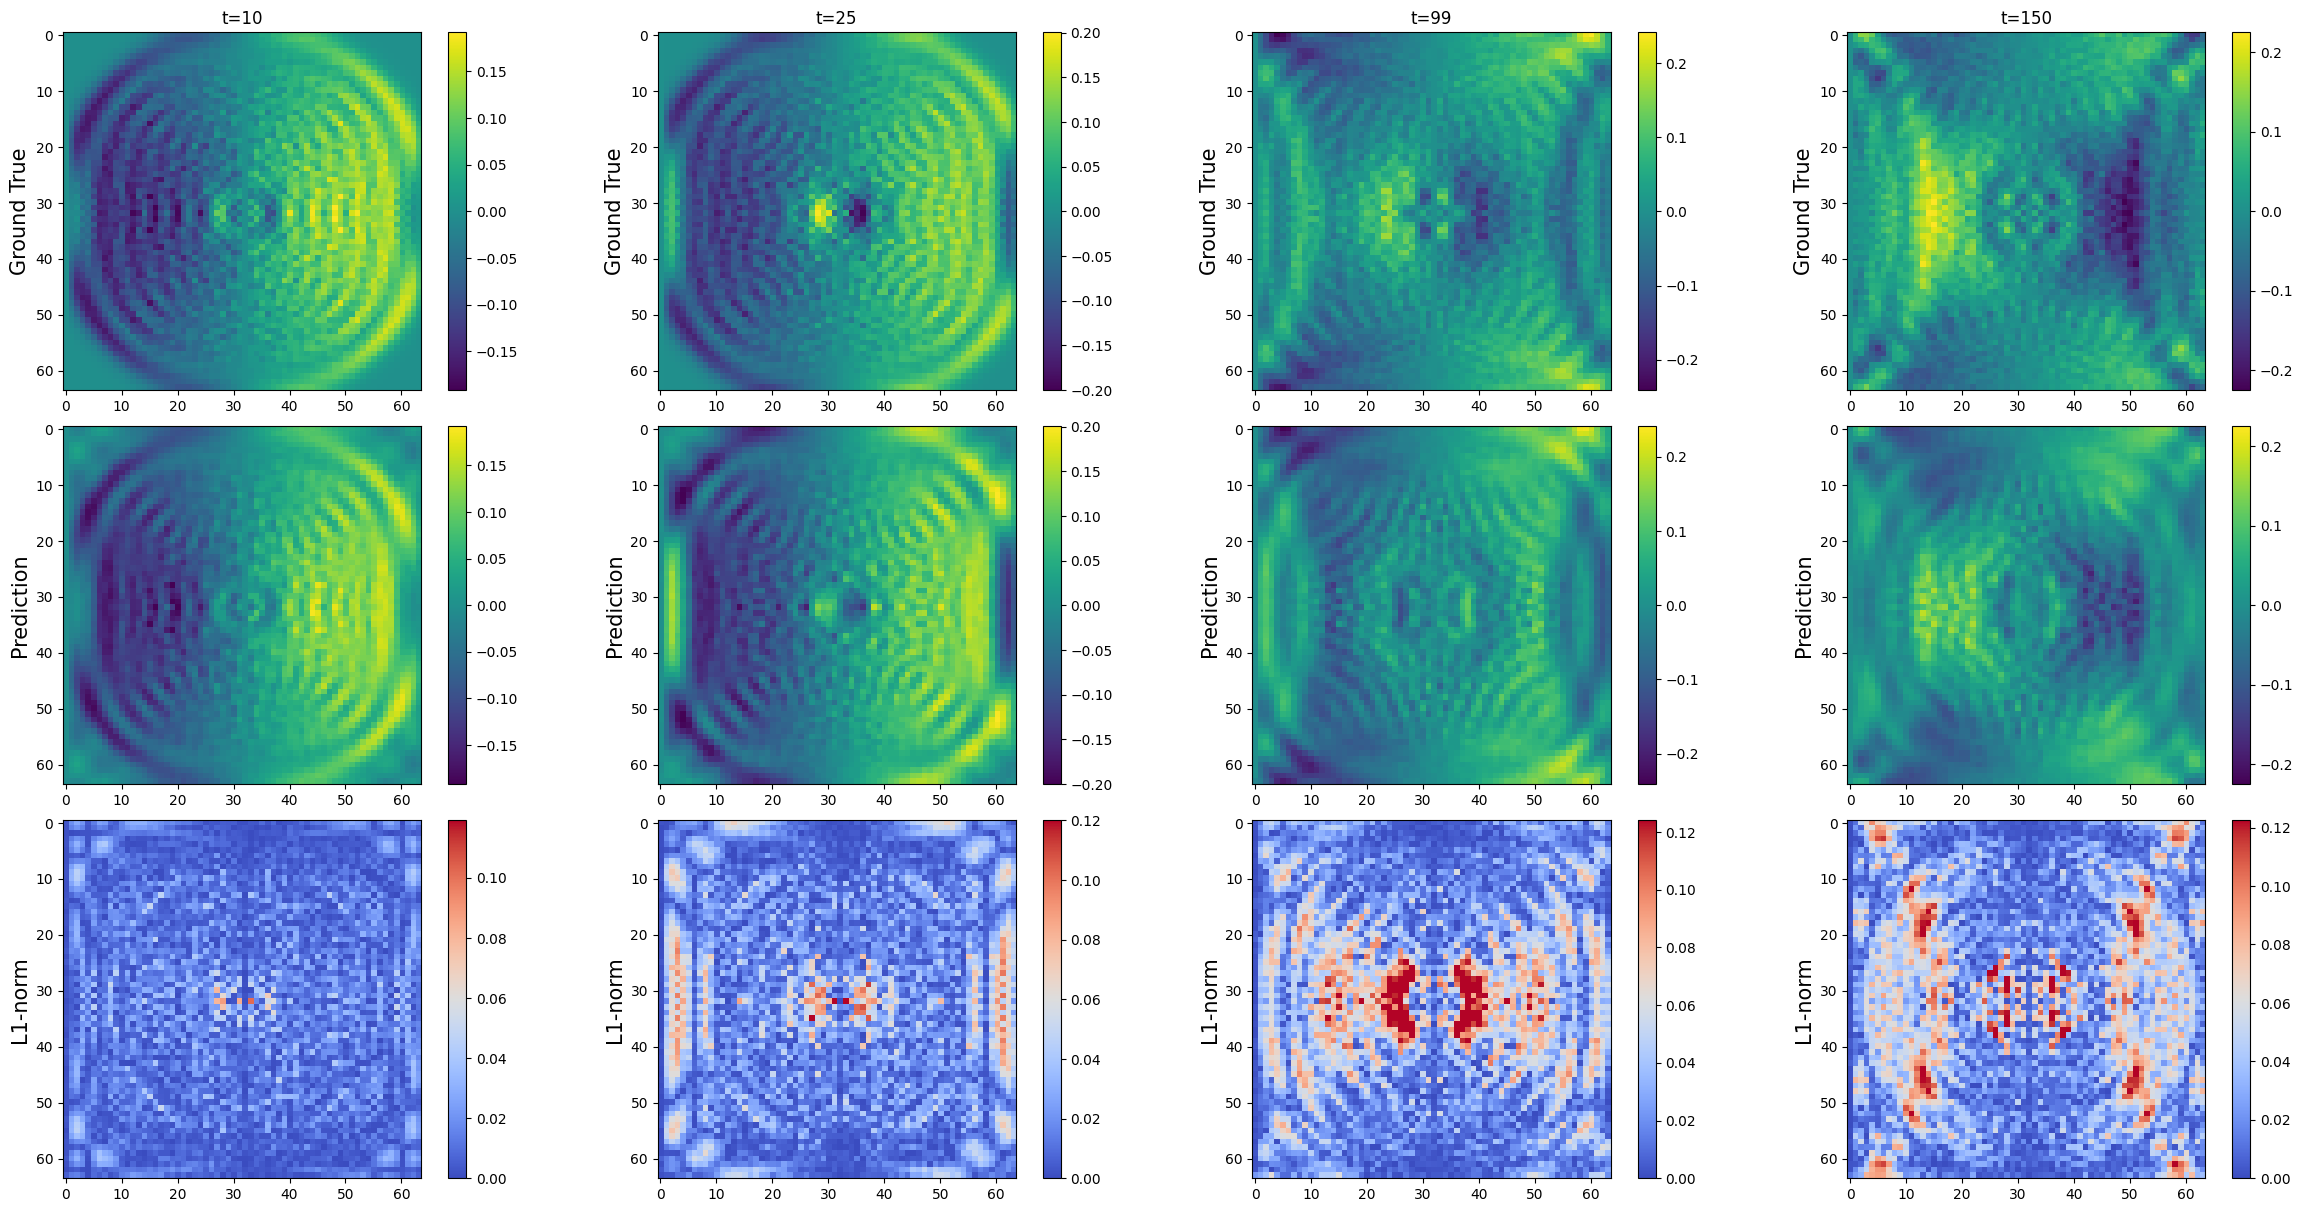

In [24]:
basic_hist = results_plot.plot_images_and_loss(test_data, basic_predictions, 0, batch_num, num, nDisplay, initial_gap=0, name='Basic')

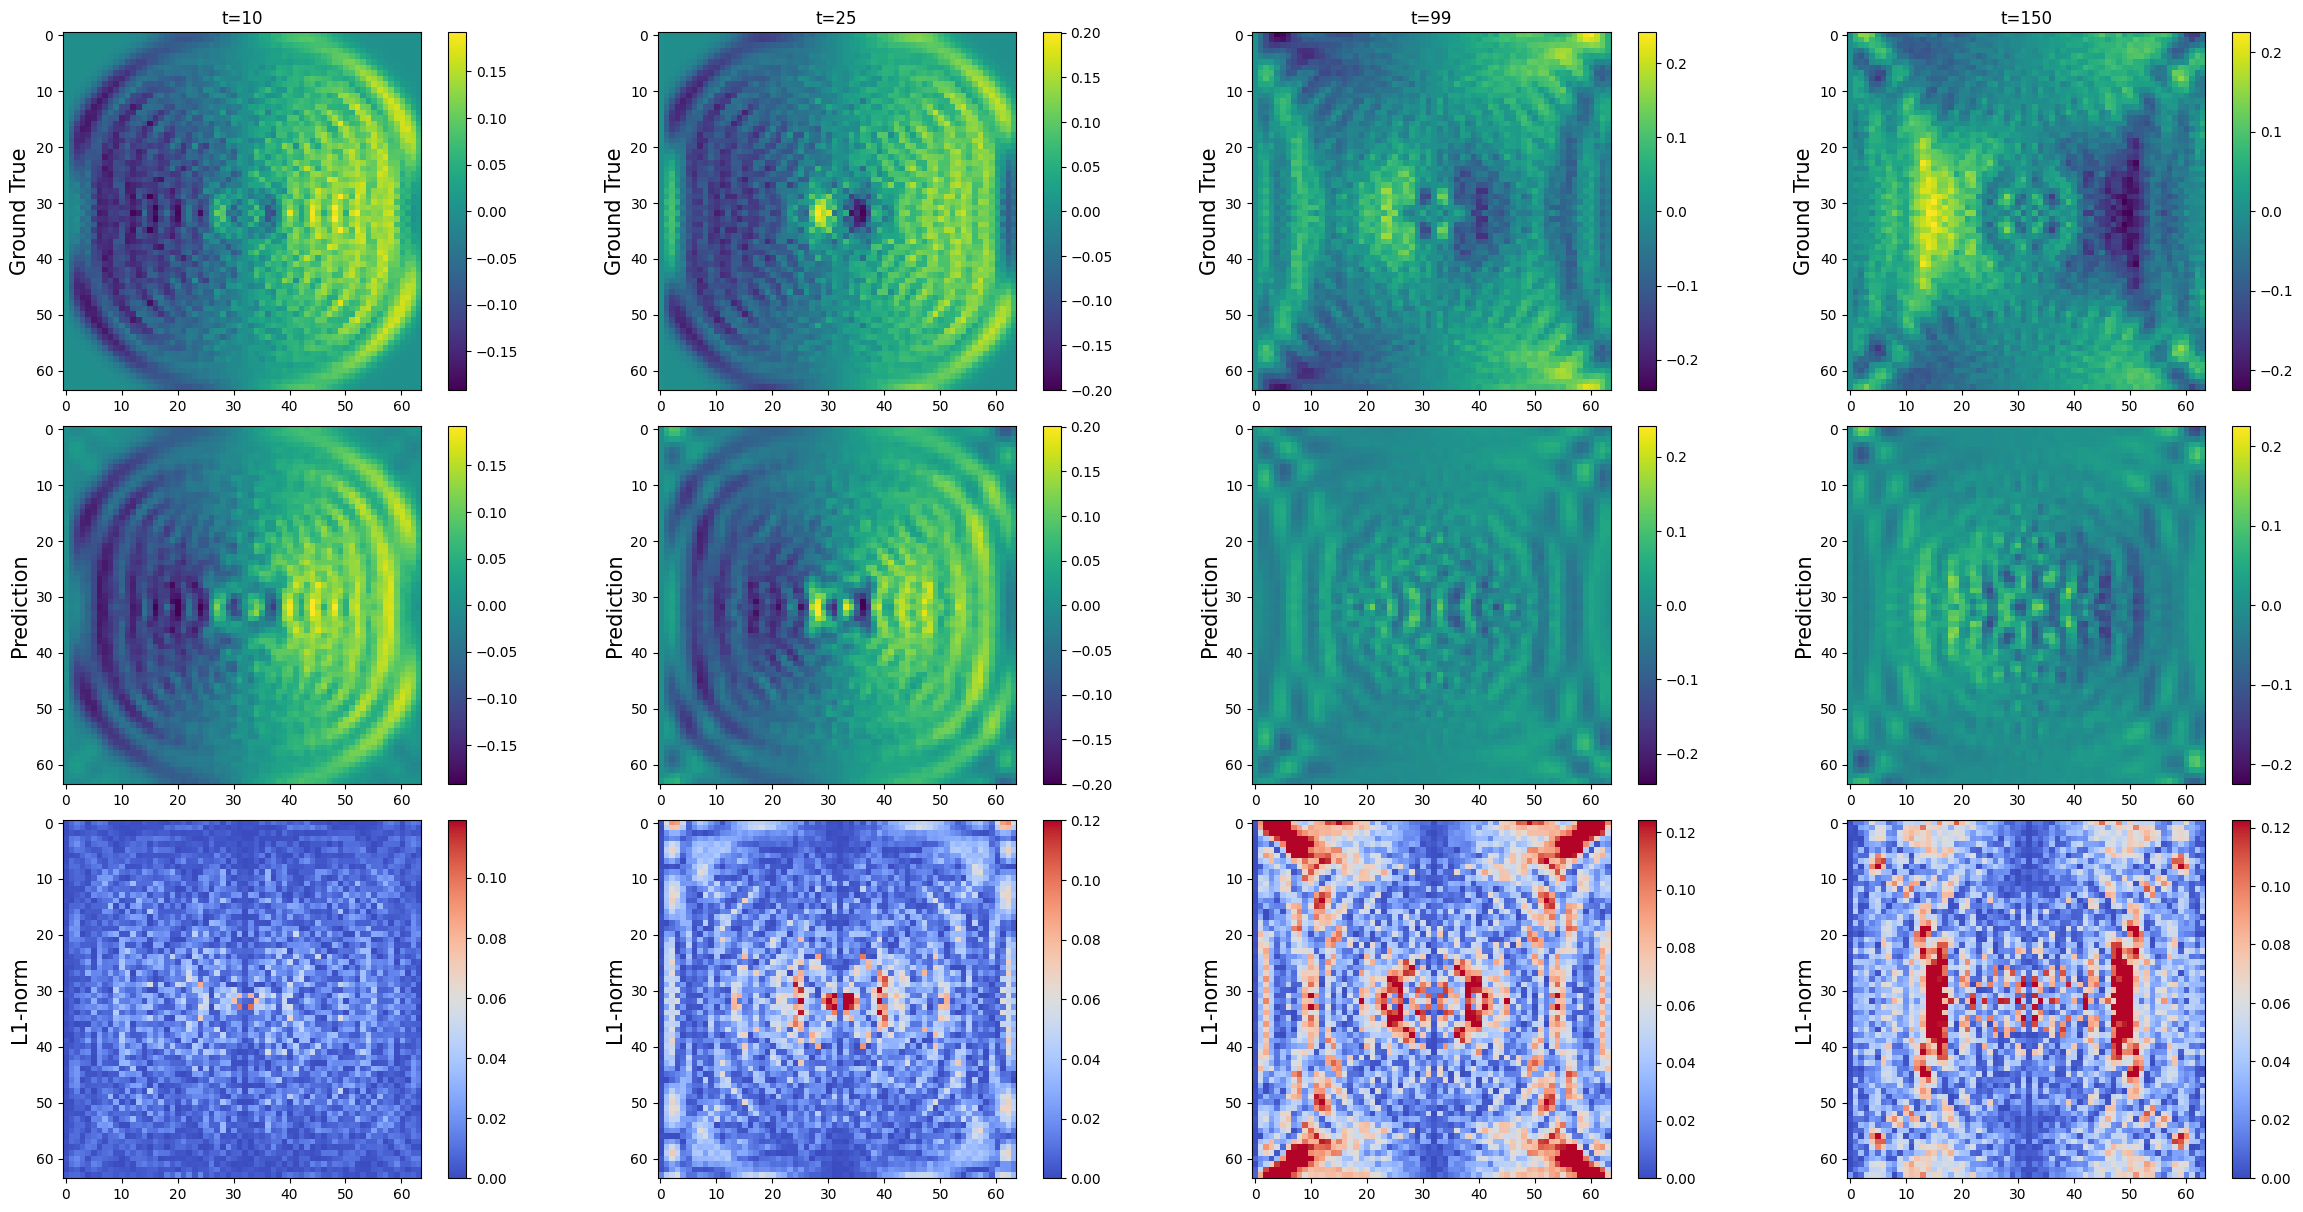

In [25]:
ec_low_hist = results_plot.plot_images_and_loss(test_data, lf_ec_predictions, 0, batch_num, num, nDisplay, name='EC in Low Fidelity Cons')

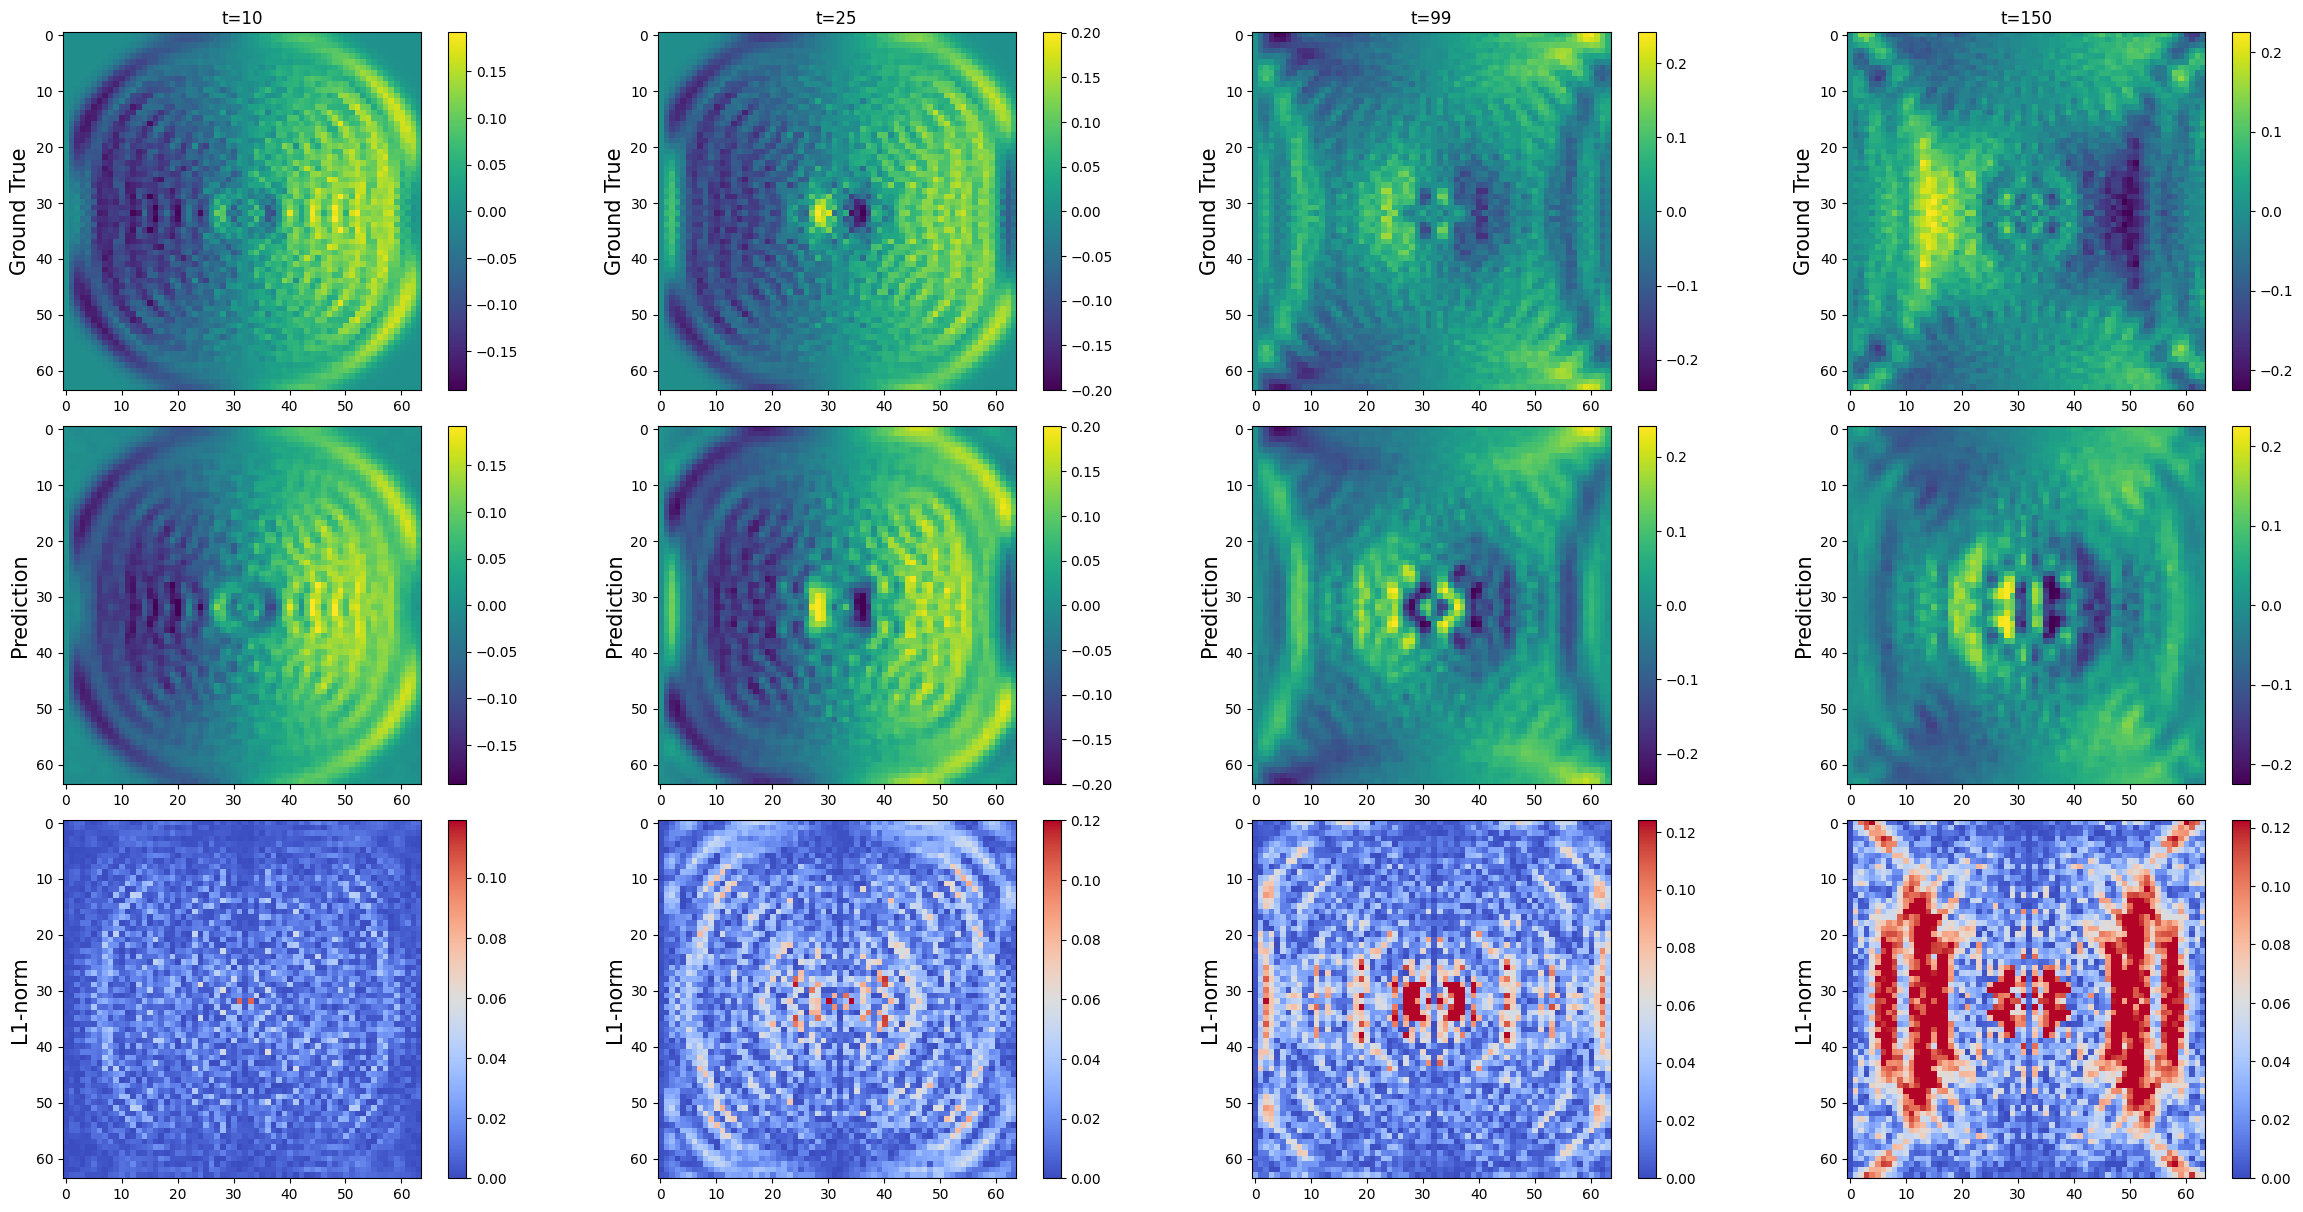

In [26]:
fo_low_hist = results_plot.plot_images_and_loss(test_data, lf_fo_predictions, 0, batch_num, num, nDisplay, name='FO in Low Fidelity Cons')

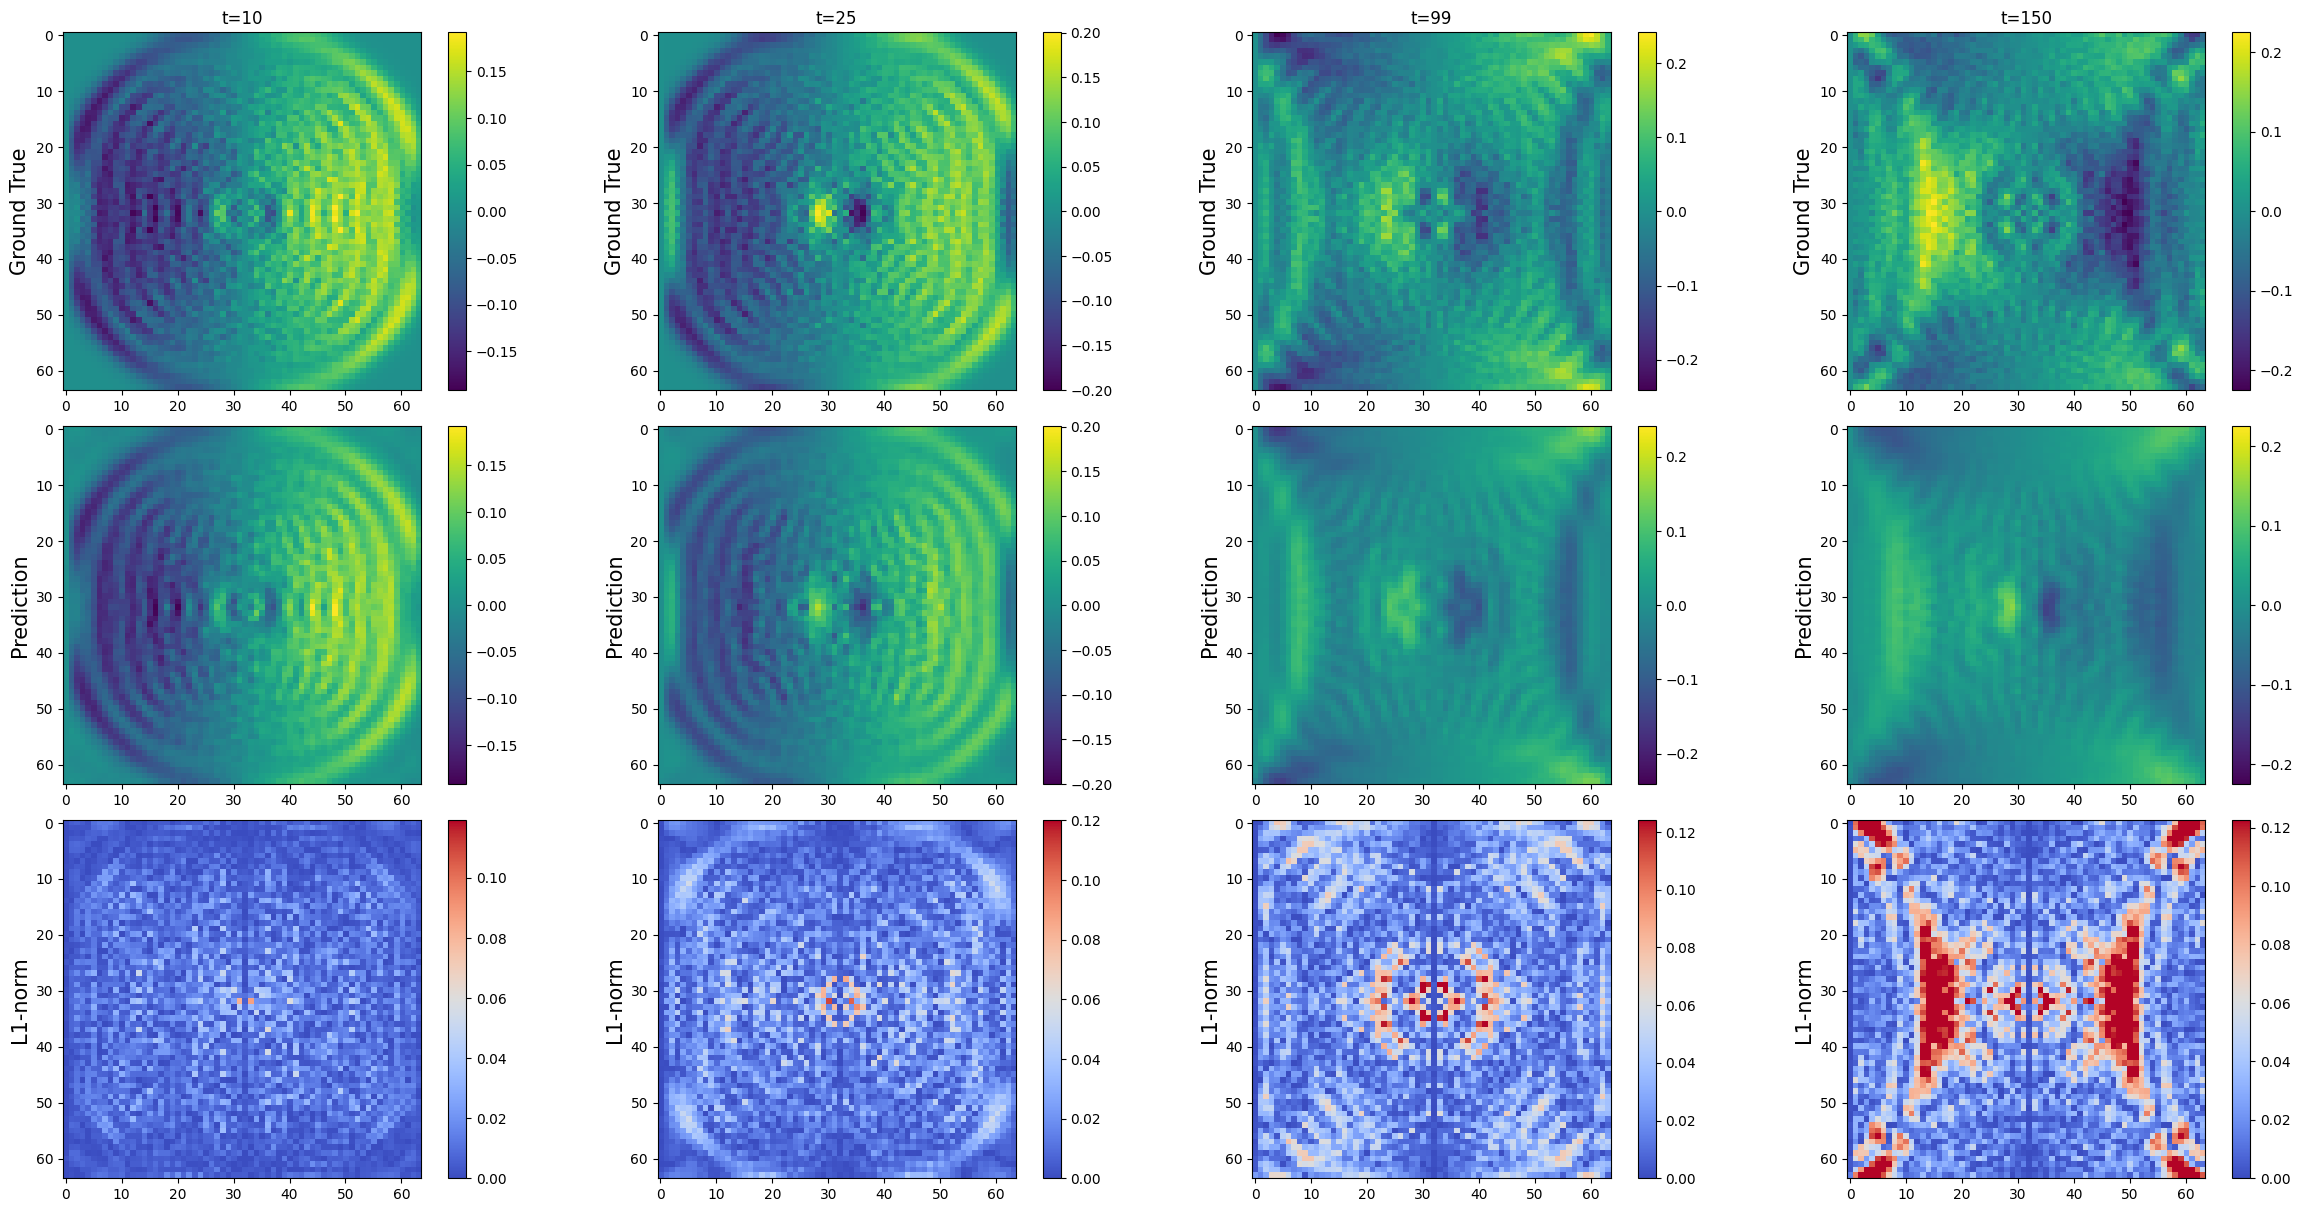

In [27]:
multi_low_hist = results_plot.plot_images_and_loss(test_data, lf_multi_predictions, 0, batch_num, num, nDisplay, name='MultiCons in Low Fidelity Cons')

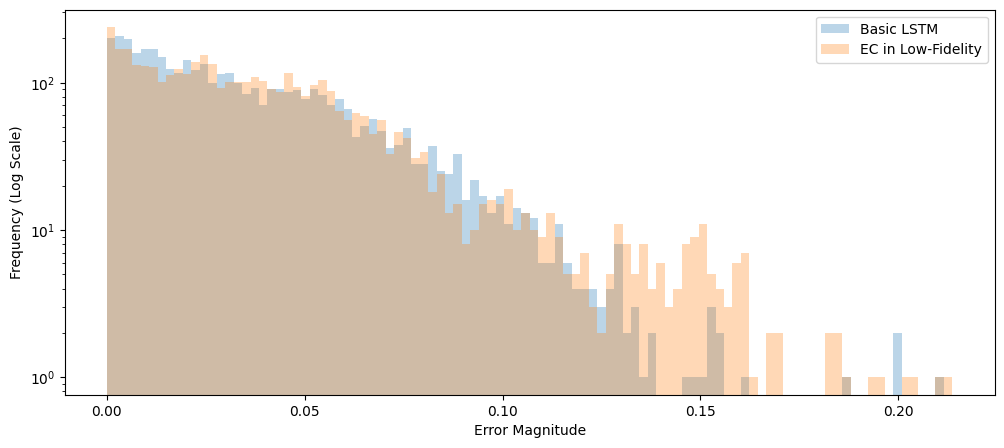

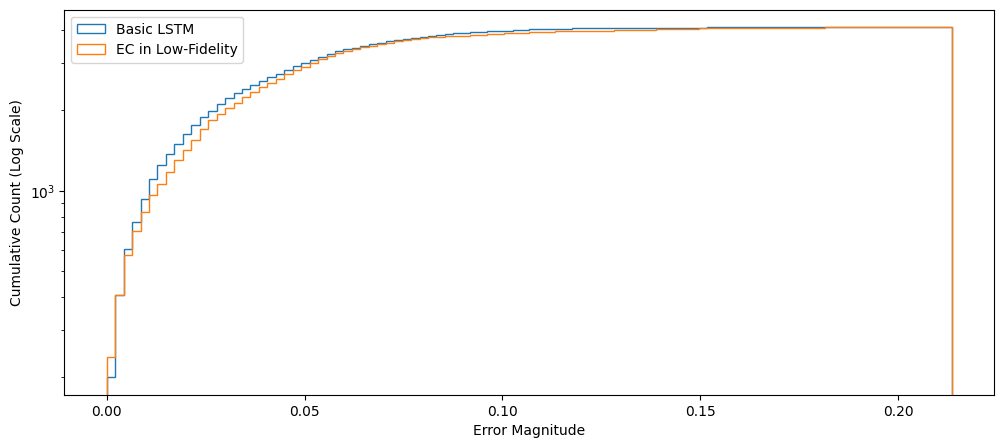

In [28]:
results_plot.plot_histograms(basic_hist[-1], ec_low_hist[-1], labels=['Basic LSTM', 'EC in Low-Fidelity'])

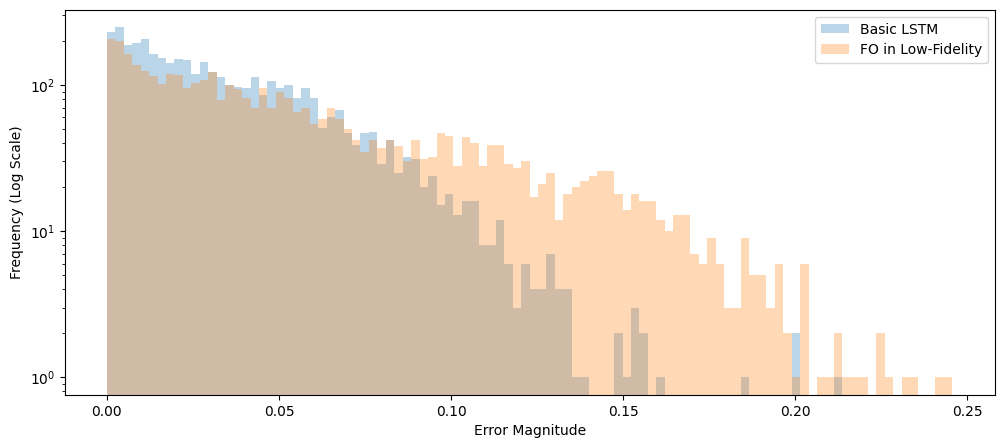

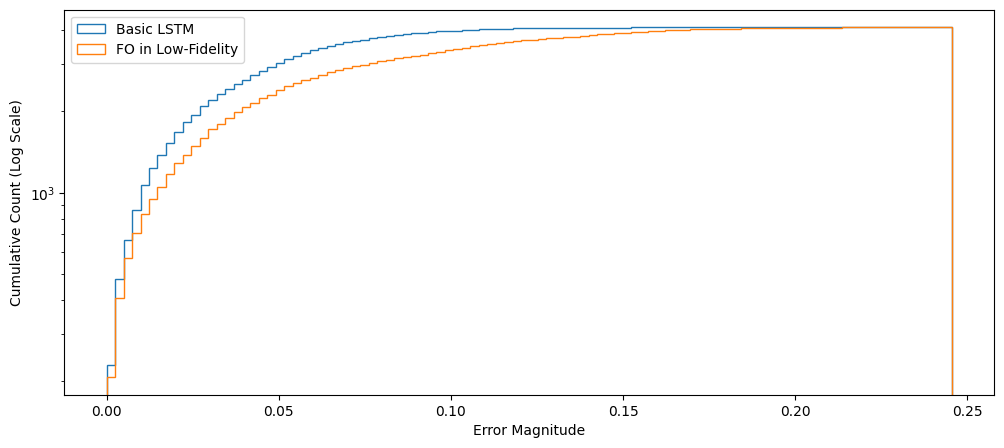

In [29]:
results_plot.plot_histograms(basic_hist[-1], fo_low_hist[-1], labels=['Basic LSTM', 'FO in Low-Fidelity'])

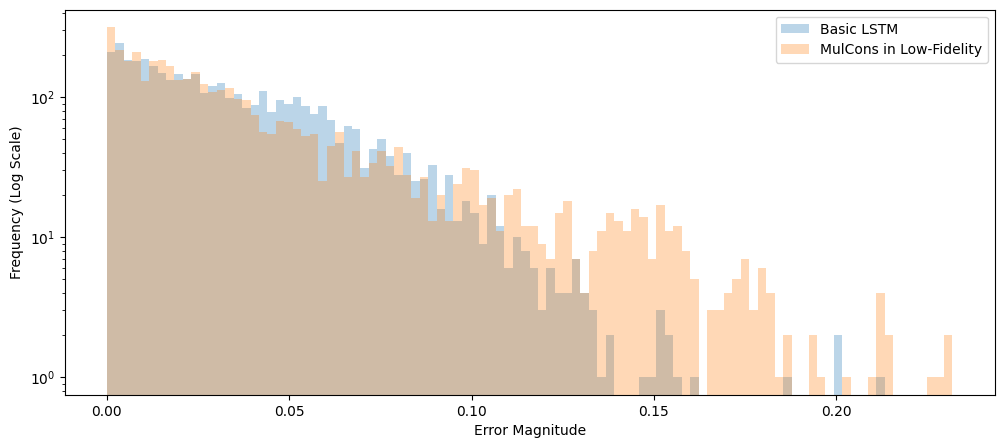

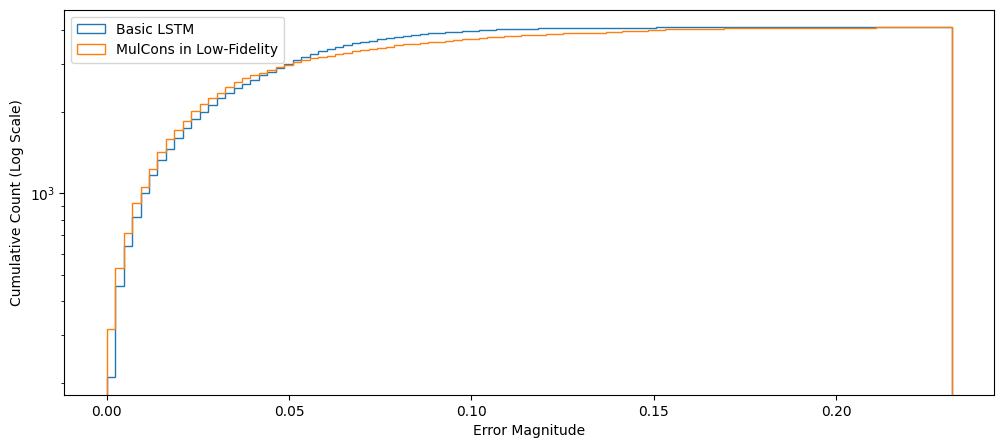

In [30]:
results_plot.plot_histograms(basic_hist[-1], multi_low_hist[-1], labels=['Basic LSTM', 'MulCons in Low-Fidelity'])